In [2]:
#ignore
from IPython.core.display import HTML,Image
HTML('<style>{}</style>'.format(config.CSS))

##### IMPORTS ######
import sys
sys.path.append('/anaconda/')
import config

sys.path.append(config.REPO_ROOT+'data/')
from prices.eod import read


## Introduction
Most investors have heard the adage "Sell in May and go away" which reflects the common wisdom that markets perform less well during the summer months than during the winter.  This anomaly is well described [here](https://www.investopedia.com/news/truth-about-sell-may-and-go-away/).  

Many widely held beliefs go away, precisely because they're widely held and get priced into the market.  I'd like to test the "sell in May" myth to see how well it has held up.  

This is also a great case example to illustrate seasonality analysis - something which I believe gets too little attention because it seems "too simple" to work.  Not nearly enough MACD-stochastic-crossover-descending triangles involved!

In [175]:
## Imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

First things first - we'll load returns data.  You'll need to replace this code for your data source of choice, but make sure you use _adjusted_ returns, since unadjusted returns will introduce all sorts of errors related to dividend dates, changes in yield, splits and so forth.

Also, I'm going to use log returns here since they're additive across time.  In other words, the sum of daily log returns is equal to the monthly log return, which is not (quite) true of simple returns.  Since we are mostly using daily returns, you can more or less think of the log returns as simple returns.  

Our dataset goes back to the beginning of SPY in 1993

In [197]:
## Load Data
symbols = ['SPY']
prices = read.get_symbols_close(symbols,adjusted=True)
returns = prices.pct_change()
log_ret = np.log(prices).diff()
spy = log_ret.SPY.dropna()
print(spy.head())


date
1993-02-01    0.007087
1993-02-02    0.002116
1993-02-03    0.010515
1993-02-04    0.004175
1993-02-05   -0.000695
Name: SPY, dtype: float64


First things first, we'll look at returns by calendar month.  

Text(0.5,1,'Avg Log Return (%): by Calendar Month (1993-present)')

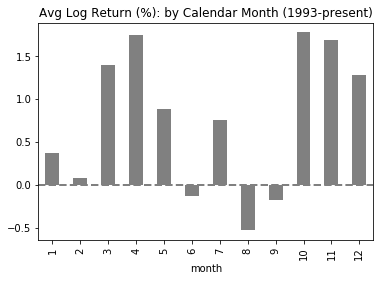

In [198]:
# Sell in May and go away!

df = spy.to_frame(name='pct_chg')
by_month = df.resample('BM').sum()
by_month['month'] = by_month.index.month

title='Avg Log Return (%): by Calendar Month (1993-present)'
ax = (by_month.groupby('month').pct_chg.mean()*100).plot\
.bar(color='grey')
ax.axhline(y=0.00, color='grey', linestyle='--', lw=2)
ax.set_title(title)


Most commonly, the "sell in May and go away" axiom advises selling on May 1st and re-entering the market on November 1st.  From the above chart, it appears than we'd be well advised to sell on June 1st and buy back on September 30th.  However, to follow the common belief, I'll stick with May 1st to Oct 31st.

I'll group the data into those two periods and calculate the monthly average:

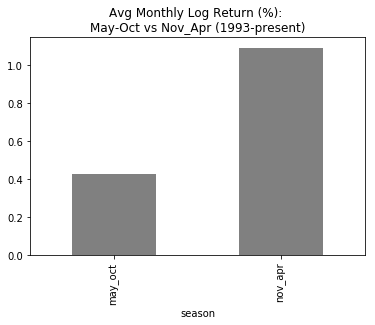

In [235]:
# create flag 
by_month['season'] = None
by_month.loc[by_month.month.between(5,10),'season'] = 'may_oct'
by_month.loc[~by_month.month.between(5,10),'season'] = 'nov_apr'

(by_month.groupby('season').pct_chg.mean()*100).plot.bar\
(title='Avg Monthly Log Return (%): \nMay-Oct vs Nov_Apr (1993-present)'\
 ,color='grey')


Clearly true.  June thru September are about flat on a total returns basis (because we're using dividend adjusted data here...)

If we were to re-run with the classical May 1 to Oct 31 definition, the summer would become net positive, but still far behind the remaining months.  

But has this anomaly been taken out of the market by genius quants and vampire squid?  Let's look at this breakout by year:

Text(0.5,1,'Avg Monthly Log Return (%): \nMay-Oct vs Nov-Apr (1993-present)')

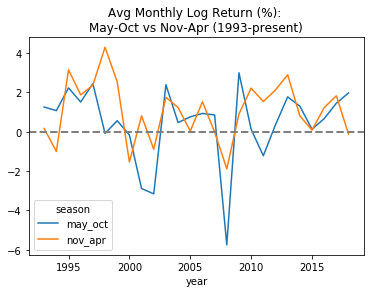

In [236]:
# by year 
by_month['year'] = by_month.index.year

title='Avg Monthly Log Return (%): \nMay-Oct vs Nov-Apr (1993-present)'
ax = (by_month.groupby(['year','season']).pct_chg.mean().unstack()*100).plot()
ax.axhline(y=0.00, color='grey', linestyle='--', lw=2)
ax.set_title(title)



It's a bit noisy, so let's make a four year rolling average (you'll see why I choose four years in a minute...):

Text(0.5,1,'Avg Monthly Log Return (%) by Season\nFour Year Moving Average (1993-present)')

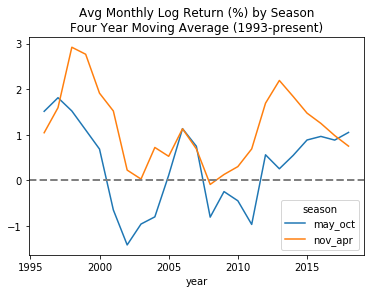

In [237]:
# by year 
title='Avg Monthly Log Return (%) by Season\nFour Year Moving Average (1993-present)'
by_month['year'] = by_month.index.year
ax = (by_month.groupby(['year','season']).pct_chg.mean().unstack().rolling(4).mean()*100).plot()
ax.axhline(y=0.00, color='grey', linestyle='--', lw=2)
ax.set_title(title)



It appears that the effect hasn't gone away at all - in fact about middle of the road: more than the late 2000's and less than the early 2000's.  

One theory I've seen floated is that this is predominantly driven by presidential elections - and the market uncertainty thereof.  To test that, I'll group data into election years and non-election years:

Text(0.5,1,'Average Monthly Returns (log) for Non-Election Years vs. Election Years')

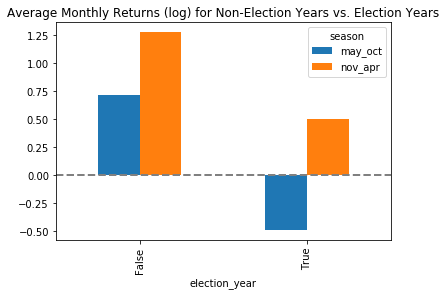

In [238]:
# presidential year
# theory may be that uncertainty prior to election leads markets to sell off.  Certainty after Election causes end of year rally

election_years = ['1996','2000','2004','2008','2012','2016']
by_month['election_year'] = False
by_month.loc[by_month.year.isin(election_years),'election_year'] = True

title = 'Average Monthly Returns (log) for Non-Election Years vs. Election Years'
ax = (by_month.groupby(['election_year','season']).pct_chg.mean()\
      .unstack()*100).plot.bar()
ax.axhline(y=0.00, color='grey', linestyle='--', lw=2)
ax.set_title(title)



Indeed, there does appear to be _more_ truth to the axiom in election years, but it remains significantly valid in off years as well.  

Mark Hulbert [analyzed this theory](https://www.marketwatch.com/story/heres-the-real-story-behind-sell-in-may-and-go-away-2017-04-25) back to 1897 and sees similar results.  


Now that we've validated our first pattern, I'd like to test for other calendar patterns.  

Let's first look at days of week, looking at the average return by day of week:

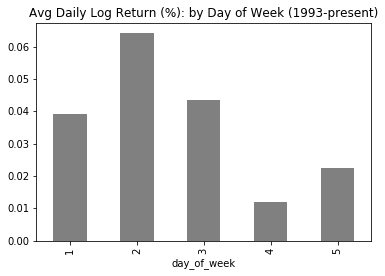

In [239]:
## Day of Week, 
df = spy.to_frame(name='pct_chg')
by_day = df
by_day['day_of_week'] = by_day.index.weekday+ 1

(by_day.groupby('day_of_week').pct_chg.mean()*100).plot.bar\
(title='Avg Daily Log Return (%): by Day of Week (1993-present)',color='grey')


This seems promising.  Monday to Weds seems significantly better than Thurs and Friday.  Anyone care to hypothesize why?

I'll follow the same code pattern as with the "sell in May" analysis and group the days into these two halves, calculate in total as well as on a four-year-rolling basis.  

Text(0.5,1,'Avg Daily Log Return (%) by Part of Week\nFour Year Moving Average (1993-present)')

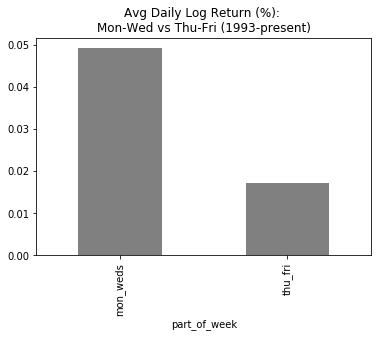

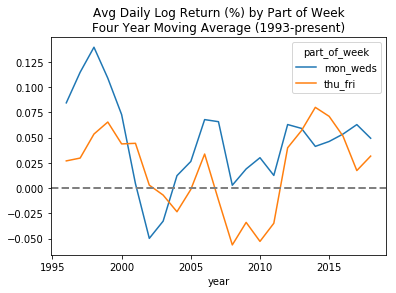

In [240]:
by_day['part_of_week'] = None
by_day.loc[by_day.day_of_week <=3,'part_of_week'] = 'mon_weds'
by_day.loc[by_day.day_of_week >3,'part_of_week'] = 'thu_fri'

(by_day.groupby('part_of_week').pct_chg.mean()*100).plot.bar\
(title='Avg Daily Log Return (%): \nMon-Wed vs Thu-Fri (1993-present)'\
 ,color='grey')

title='Avg Daily Log Return (%) by Part of Week\nFour Year Moving Average (1993-present)'
by_day['year'] = by_day.index.year
ax = (by_day.groupby(['year','part_of_week']).pct_chg.mean().unstack().rolling(4).mean()*100).plot()
ax.axhline(y=0.00, color='grey', linestyle='--', lw=2)
ax.set_title(title)


The average daily return (log) for Mon to Weds is considerably more than 2x the daily return of Thursdays and Fridays.   

It also appears to be a good bit less stable than the "sell-in-May" results.   I'd be hesitant to say that the anomaly is dead, however.  Just periodically dormant.  

Now let's look at the day of month:

Text(0.5,1,'Avg Daily Log Return (%): by Day of Month (1993-present)')

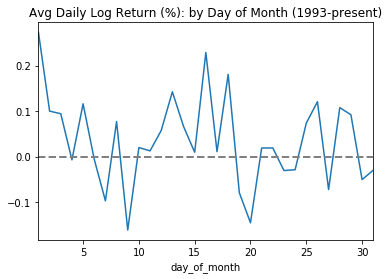

In [241]:
## Day of Month

by_day['day_of_month'] = by_day.index.day 

title='Avg Daily Log Return (%): by Day of Month (1993-present)'

ax = (by_day.groupby('day_of_month').pct_chg.mean()*100).plot(xlim=(1,31))
ax.axhline(y=0.00, color='grey', linestyle='--', lw=2)
ax.set_title(title)

It seems pretty clear that there are some parts of the month which, on average, have much better/worse returns.  By my eye, it appears that the change of month (from about the 28th to the 5th) as well as the early/mid-part of month (say 11th thru 18th) are the "good" days and the rest are not.  

I'll follow the same approach and group the data into the "good days" (28-5, 11-18) and the "other days":  

Text(0.5,1,'Avg Daily Log Return (%) by Part of Month\nFour Year Moving Average (1993-present)')

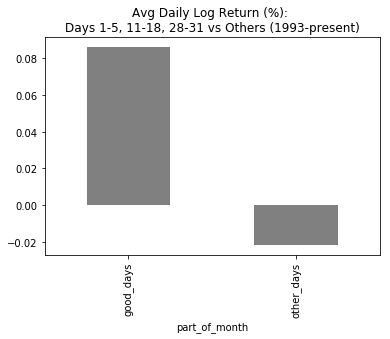

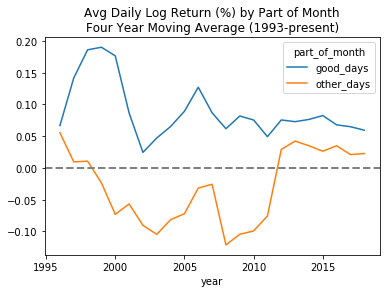

In [242]:
by_day['part_of_month'] = None
good_days = [1,2,3,4,5,11,12,13,14,15,16,17,18,28,29,30,31]
by_day.loc[by_day.day_of_month.isin(good_days),'part_of_month'] = 'good_days'
by_day.loc[~by_day.day_of_month.isin(good_days),'part_of_month'] = 'other_days'

(by_day.groupby('part_of_month').pct_chg.mean()*100).plot.bar\
(title='Avg Daily Log Return (%): \nDays 1-5, 11-18, 28-31 vs Others (1993-present)'\
 ,color='grey')

title='Avg Daily Log Return (%) by Part of Month\nFour Year Moving Average (1993-present)'
by_day['year'] = by_day.index.year
ax = (by_day.groupby(['year','part_of_month']).pct_chg.mean().unstack().rolling(4).mean()*100).plot()
ax.axhline(y=0.00, color='grey', linestyle='--', lw=2)
ax.set_title(title)



Systematic investing in the 90's and 00's must have been easy!  

However, even since the spread between the favorable days (end/beginning of month + middle of month) vs. the other days has narrowed, it is still quite significant.  The below table shows the past 5 years' returns.  It's not even close...

Again, I'm quite interested in hypotheses.  
* Institutional/Retail fund flows?  
* Options/futures settlements?  
* Window dressing?
* Buybacks?  

In [243]:
print(by_day.groupby(['year','part_of_month']).pct_chg.mean().unstack().tail(5)*100)

part_of_month  good_days  other_days
year                                
2014            0.080266    0.014217
2015            0.022733   -0.016077
2016            0.058032    0.029643
2017            0.098606    0.056520
2018            0.058509    0.020563


## Conclusion

As irrational as it may seem, there are some major seasonality effects remaining in even the most liquid markets.  Quite honestly, this is __much__ more significant than I expected to find.  If any of my fellow skeptics want to replicate this on their own datasets, please message me with your results.  

If the future looks anything like the past (insert standard disclaimer about past performance...) then rules of thumb might be:
* Sell on Labor Day and buy on Halloween - especially do this on election years!  This assumes that you've got a productive use for the cash!  
* Do your buying at Friday's close, do your selling at Wednesday's close
* Maximize your exposure at the end/beginning of months and during the early-middle part of the month, lighten up.
* Remember

PS - I had intended to extend this analysis to other asset classes, but will save that for a future post.  I'd like to expand this to small caps, rest-of-world developed/emerging, fixed income, growth, value, etc... 


### One last thing...

If you've found this post useful, please follow [@data2alpha](https://twitter.com/data2alpha) on twitter and forward to a friend or colleague who may also find this topic interesting.

Finally, take a minute to leave a comment below.  Share your thoughts on this post or to offer an idea for future posts.  Thanks for reading!